In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import LabelEncoder
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [5]:
sales = pd.read_csv('raw_sales.csv')
properti = pd.read_csv('ma_lga_12345.csv')

In [6]:
# berisi data penjualan rumah dari 2007-2019
sales.head(2)


,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3


In [7]:
# melakukan rename kolom untuk mempermudah penggabungan
sales.rename(columns={'propertyType': 'type'}, inplace=True)
# merubah type data waktu
sales['datesold'] = pd.to_datetime(sales['datesold'])
properti['saledate'] = pd.to_datetime(properti['saledate'])

<ipython-input-7-d91b72fc08bb>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  properti['saledate'] = pd.to_datetime(properti['saledate'])


In [8]:
# menambah kolom baru
sales['years']= sales['datesold'].dt.year
sales['quartal'] = sales['datesold'].dt.quarter
properti['years']= properti['saledate'].dt.year
properti['quartal'] = properti['saledate'].dt.quarter

In [9]:
properti.head(2)

,saledate,MA,type,bedrooms,years,quartal
0,2007-09-30,441854,house,2,2007,3
1,2007-12-31,441854,house,2,2007,4


In [10]:
# menggabungkan kedua data frame
df = pd.merge(sales, properti, on=['type', 'bedrooms','years','quartal'], how= 'left')
df.head(2)

,datesold,postcode,price,type,bedrooms,years,quartal,saledate,MA
0,2007-02-07,2607,525000,house,4,2007,1,2007-03-31,548969.0
1,2007-02-27,2906,290000,house,3,2007,1,2007-03-31,421291.0


In [11]:
data = df[['datesold','bedrooms','price','MA']]
data.sample(2)

,datesold,bedrooms,price,MA
582,2008-11-28,3,1250000,426488.0
13655,2015-12-10,3,389000,549278.0


In [12]:
# merubah kolom tahun menjadi index
data.set_index('datesold',inplace=True)
data.sample(2)

,bedrooms,price,MA
datesold,,,
2009-05-14,1,160000,323556.0
2013-12-18,3,410000,506406.0


## EDA

In [13]:
# melakukan analisa jenis properti yang paling diminati
postcode_unit = sales.groupby(['bedrooms','type','postcode']).agg({'price':'count'}).reset_index().rename(columns={'price': 'count'})
postcode_unit.sample(2)

,bedrooms,type,postcode,count
164,4,house,2605,299
142,3,unit,2605,49


Text(0.5, 1.0, 'Counts Bedrooms')

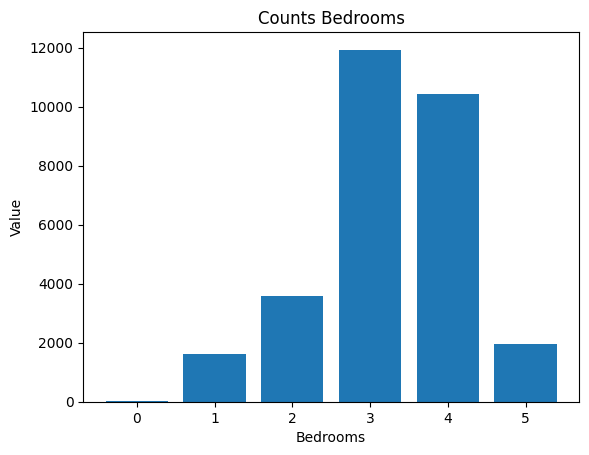

In [14]:
bedrooms = postcode_unit.groupby('bedrooms').agg({'count':'sum'}).reset_index()
plt.bar(bedrooms['bedrooms'],bedrooms['count'])
plt.xlabel('Bedrooms')
plt.ylabel('Value')
plt.title('Counts Bedrooms')


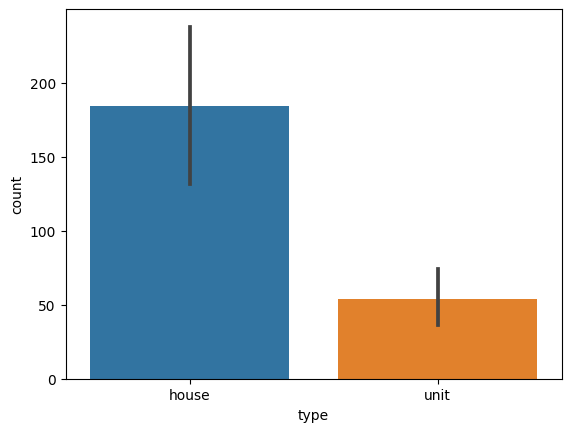

In [15]:
sns.barplot(x='type', y='count', data=postcode_unit)
plt.show()

Penjualan paling banyak ada rumah yang memiliki bedrooms sebanyak 3 dan 4 sebesar 11933 dan 10442

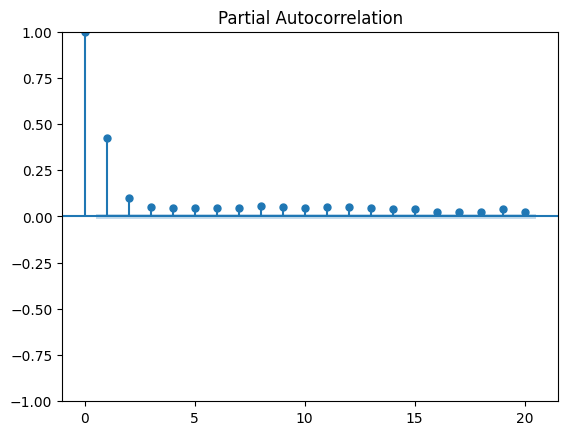

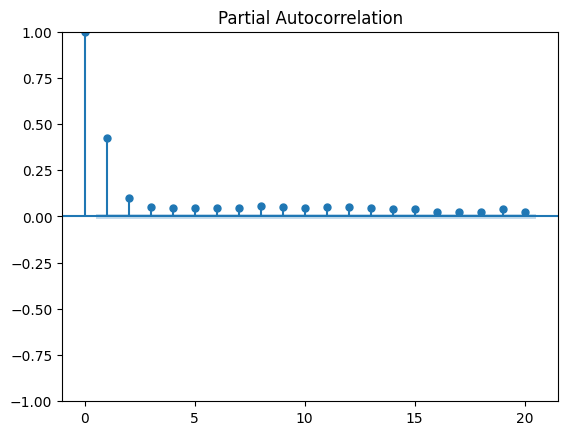

In [16]:
# menentukan nlai order dengan menggunaka auto arima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(data['price'],lags=20) # maka nilai q = 1

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

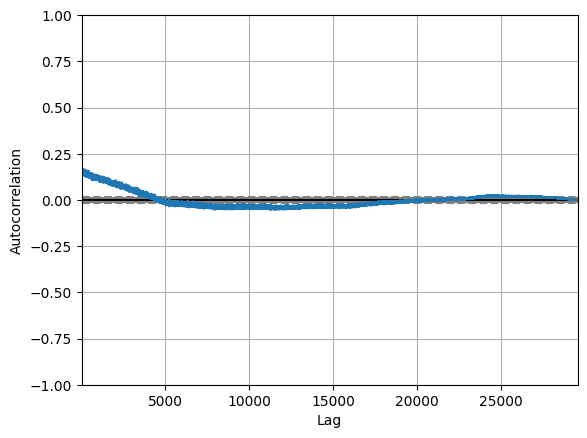

In [37]:
pd.plotting.autocorrelation_plot(data['price']) # p = 0

<Figure size 640x480 with 0 Axes>

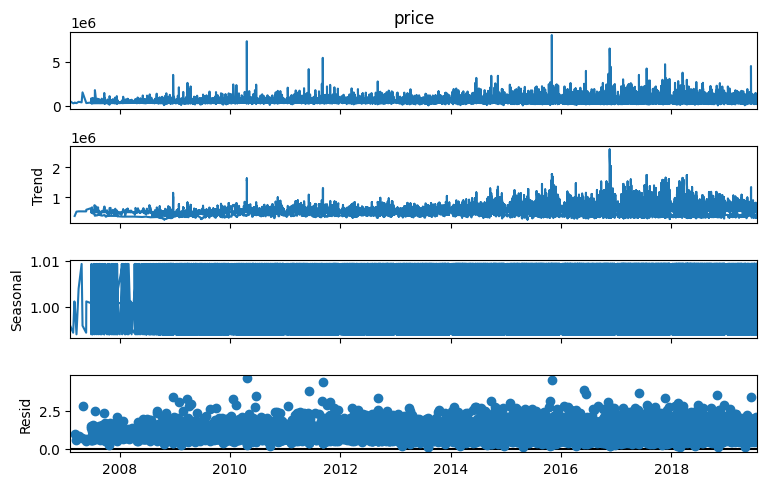

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['price'], model= 'multiplicative', period=7)
fig = plt.figure()
fig= result.plot()
fig.set_size_inches(8,5)

In [19]:
# mencari order terbaik dengan model auto arima
model= auto_arima(data['price'], trace = True,
                  suppress_warnings= True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=830524.053, Time=0.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=826383.319, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=821716.073, Time=10.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=830522.053, Time=2.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=25.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.95 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=821712.805, Time=6.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=10.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=10.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=826381.319, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=14.77 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 136.322 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                29580
Model:               SARIMAX(0, 1, 1)   Log Likelihood             -410854.402
Date:                Fri, 27 Oct 2023   AIC                         821712.805
Time:                        06:08:55   BIC                         821729.395
Sample:                             0   HQIC                        821718.131
                              - 29580                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9874      0.001  -1394.110      0.000      -0.989      -0.986
sigma2      7.354e+10   2.28e-15   3.23e+25      0.000    7.35e+10    7.35e+10
===================================================================================
Ljung-Box (L1) (Q):                2946.89   Jarque-Bera (JB):           6030100.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             4.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        72.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Bahwa dataset yg dimiliki sudah seasonal, tidak memiliki trend namun terdapat musiman. Dengan begitu saya memutuskan tidak melakukan differencing. Untuk mendapatkan nilai order yang optimal saya menggunaka model auto arima.


In [33]:
order = (1,1)
exog_data = data['bedrooms']

model = VARMAX(data[['price','MA']], order=order,exog=exog_data)
results = model.fit(maxiter=1000, disp=False)
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:        ['price', 'MA']   No. Observations:                29580
Model:                    VARMAX(1,1)   Log Likelihood             -803243.818
                          + intercept   AIC                        1606517.636
Date:                Fri, 27 Oct 2023   BIC                        1606642.059
Time:                        07:18:52   HQIC                       1606557.585
Sample:                             0                                         
                              - 29580                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           2737.86, nan   Jarque-Bera (JB):   7654244.16, 1093.34
Prob(Q):                         0.00, nan   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         1.18, 1.71   Skew:                        5.12, 0.46
Prob(H) (two-sided):            0.

# menampilkan fungsi respon impluse dari variabel data
ax = results.impulse_responses(8, orthogonalized=True, impluse=[1,0]).plot(figsize=(10,4))
ax.set(xlabel='t', title='Responses to a shock to price');

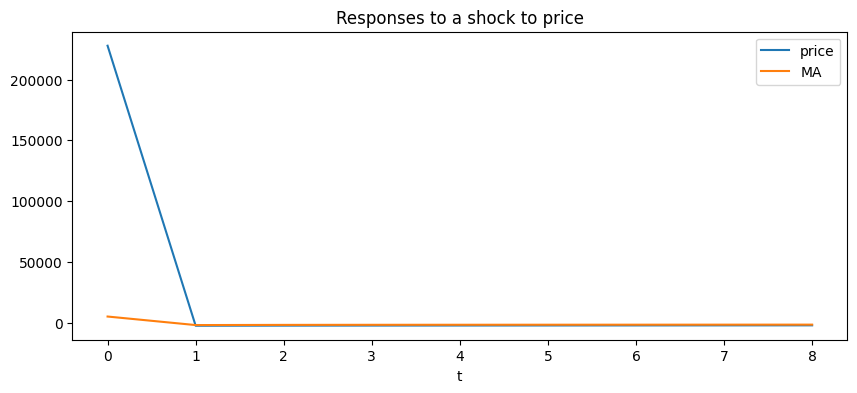

In [41]:
ax = results.impulse_responses(8, orthogonalized=True, impluse=[1,0]).plot(figsize=(10,4))
ax.set(xlabel='t', title='Responses to a shock to price');